https://cdeiuk.github.io/bias-mitigation/

In [1]:
import pandas as pd

In [2]:
url = "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/processed/train.csv"

test = pd.read_csv(url)
print(test.head())

   sex_male  race_white  years_experience  referred      gcse   a_level  \
0         0           1          0.265328         1  0.148817  1.115547   
1         0           1         -1.126253         0  0.148817  1.115547   
2         1           0         -0.082567         1  0.148817 -1.013021   
3         1           1          0.265328         1 -1.065188  0.051263   
4         1           1         -0.778358         1 -1.065188  0.051263   

   russell_group  honours  years_volunteer    income  it_skills  years_gaps  \
0              1        1         2.139888 -0.740776  -0.712629    1.428393   
1              1        1        -0.704762 -0.229262   0.363037   -0.704067   
2              0        0        -0.704762 -1.325363  -1.788296   -0.704067   
3              0        0        -0.704762  1.414890   0.363037    0.362163   
4              0        0         0.717563  0.757230   1.438704   -0.704067   

   quality_cv  employed_yes  
0   -0.919143             1  
1    0.253981 

In [3]:
print(len(test))

6000


In [4]:
# White and employed
whiteEmployed_df = test[(test['race_white'] == 0) & (test['employed_yes'] == 1)]

whiteEmployed_df_count = len(whiteEmployed_df)

print(f"White and employed: {whiteEmployed_df_count}")

White and employed: 674


In [5]:
# Colored and employed
whiteEmployed_df = test[(test['race_white'] == 0) & (test['employed_yes'] == 1)]

whiteEmployed_df_count = len(whiteEmployed_df)

print(f"Colored and employed: {whiteEmployed_df_count}")

Colored and employed: 674


In [6]:
# Male ve employed
whiteEmployed_df = test[(test['sex_male'] == 1) & (test['employed_yes'] == 1)]

whiteEmployed_df_count = len(whiteEmployed_df)

print(f"Male and employed: {whiteEmployed_df_count}")

Male and employed: 1401


In [7]:
# Female ve employed
whiteEmployed_df = test[(test['sex_male'] == 0) & (test['employed_yes'] == 1)]

whiteEmployed_df_count = len(whiteEmployed_df)

print(f"Female and employed: {whiteEmployed_df_count}")

Female and employed: 884


race ve genderların eşit olması lazım
datasette eşit AMA
white olduğunun imply eden ve black olduğunu imply eden özelliklerin de hiring kararında eşit olması lazım
bunu yapıp yapmadaıüını analiz etmemiz lazım

VE demograohic parity

In [8]:
employed_by_sex = test[["sex_male", "employed_yes"]].groupby("sex_male").mean()
print(employed_by_sex)


          employed_yes
sex_male              
0             0.295159
1             0.466223


Karar aşamasında female karakteristik insanları reject etme olasılığı daha yüksek

In [9]:
employed_by_race = test[["race_white", "employed_yes"]].groupby("race_white").mean()
print(employed_by_race)


            employed_yes
race_white              
0               0.230743
1               0.523222


Acceptad'larda eşit olsa bile rejectadlarda beyaz olmayanlar daha çok reject edilebilir -> beyaz karakteristikleri olmayanların kabul edilme olasılığı daha düşük olabilir

In [10]:
cv_by_race = test[["race_white", "quality_cv"]].groupby("race_white").mean()
print(cv_by_race)


            quality_cv
race_white            
0             0.006184
1            -0.005866


racial disparity yok -> racist bastards

In [11]:
cv_by_sex = test[["sex_male", "quality_cv"]].groupby("sex_male").mean()
print(cv_by_sex)


          quality_cv
sex_male            
0           0.009956
1          -0.009923


sexual disparity yok

In [12]:
from pathlib import Path
import joblib

!pip install fairlearn

from fairlearn.metrics import (
    demographic_parity_difference,
    demographic_parity_ratio,
    equalized_odds_difference,
    equalized_odds_ratio,
)

In [13]:
test_url = "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/processed/test.csv"
test = pd.read_csv(test_url)
test_raw_url = "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/raw/test.csv"
test_raw = pd.read_csv(test_raw_url)

model = joblib.load("baseline.pkl")

C:\Users\Faraz\anaconda3\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Faraz\anaconda3\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 0.23.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
test_prob = model.predict_proba(test.drop(columns="employed_yes"))[:, 1]
test_pred = test_prob > 0.5
test_accuracy = model.score(
    test.drop(columns="employed_yes"), test.employed_yes
)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Test accuracy: 86.15%


C:\Users\Faraz\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\Faraz\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [15]:
dpd = demographic_parity_difference(
    test.employed_yes, test_pred, sensitive_features=test.sex_male,
)
dpr = demographic_parity_ratio(
    test.employed_yes, test_pred, sensitive_features=test.sex_male,
)

print(f"Demographic parity difference: {dpd:.3f}")
print(f"Demographic parity ratio: {dpr:.3f}")

Demographic parity difference: 0.173
Demographic parity ratio: 0.590


Ratio 0.5' yakın çıktı, güzel. 0.5 olmasını istiyoruz, tam eşit olsun. Sexist olma olasılığı daha az

In [16]:
dpd = demographic_parity_difference(
    test.employed_yes, test_pred, sensitive_features=test.race_white,
)
dpr = demographic_parity_ratio(
    test.employed_yes, test_pred, sensitive_features=test.race_white,
)

print(f"Demographic parity difference: {dpd:.3f}")
print(f"Demographic parity ratio: {dpr:.3f}")

Demographic parity difference: 0.327
Demographic parity ratio: 0.345


Race'de ration yüksek. Yani racistler. 0.5'e yaklaştırmak istiyoruz. (Include DEI programs hehe)

In [17]:
eod = equalized_odds_difference(
    test.employed_yes, test_pred, sensitive_features=test.sex_male,
)
eor = equalized_odds_ratio(
    test.employed_yes, test_pred, sensitive_features=test.sex_male,
)

print(f"Equalised odds difference: {eod:.3f}")
print(f"Equalised odds ratio: {eor:.3f}")

Equalised odds difference: 0.088
Equalised odds ratio: 0.650


Difference küçücük.

In [18]:
eod = equalized_odds_difference(
    test.employed_yes, test_pred, sensitive_features=test.race_white,
)
eor = equalized_odds_ratio(
    test.employed_yes, test_pred, sensitive_features=test.race_white,
)

print(f"Equalised odds difference: {eod:.3f}")
print(f"Equalised odds ratio: {eor:.3f}")

Equalised odds difference: 0.133
Equalised odds ratio: 0.246


Bunda difference daha yüksek. Rac,st rather than sexist.

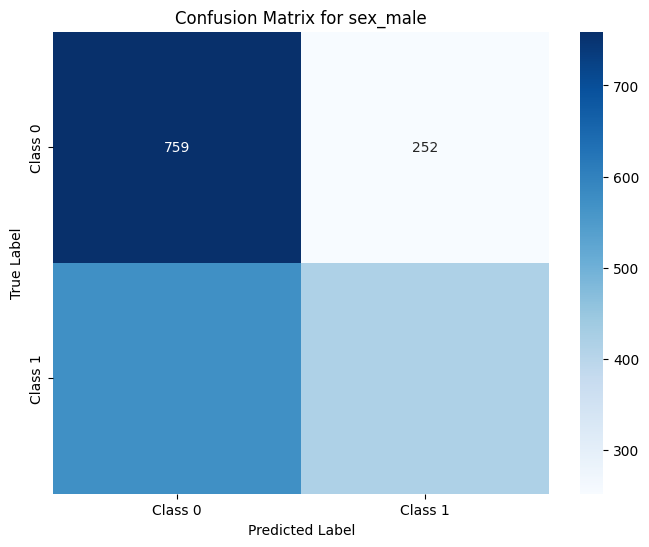

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Assuming 'test' DataFrame and 'test_pred' predictions are already defined

# Replace 'your_column_name' with the actual column name you want to use
column_of_interest = "sex_male"

# Ensure the column exists in your DataFrame
if column_of_interest in test.columns:
    # Create the confusion matrix
    cm = confusion_matrix(test[column_of_interest], test_pred)

    # Define labels for the plot (replace with your actual label names)
    labels = ['Class 0', 'Class 1'] # Replace with meaningful labels for your column

    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {column_of_interest}')
    plt.show()


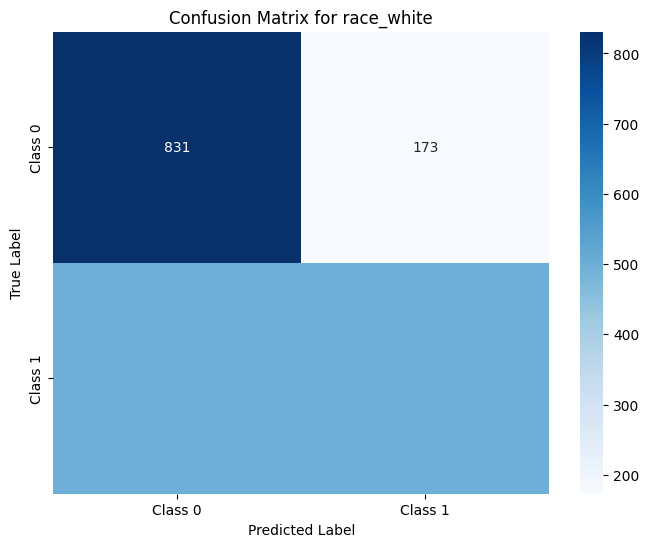

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd


column_of_interest = "race_white"

# Ensure the column exists in your DataFrame
if column_of_interest in test.columns:
    # Create the confusion matrix
    cm = confusion_matrix(test[column_of_interest], test_pred)

    # Define labels for the plot (replace with your actual label names)
    labels = ['Class 0', 'Class 1'] # Replace with meaningful labels for your column

    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {column_of_interest}')
    plt.show()


is racist

Modelin accuracy .8in üstünde olsa da protected karakteristikler var hire edilen insanlarda. Bunlardan sex herhangib ir ciddi male-female farklılığı göstermiyor. Bu yüzden bunun zerine train edilecek harhangi bir model sexism açısında ciddi bir sorun yaratmayacaktır diye tahmin ediyoruz.

On the other hand, beyazlar ve diğer ırklar arasında demografik farklılık var. Özellikle hire edilip edilmeme konusunda. Modeli race göz önünde bulundurmadan train edilse bile bu insanların karakteristikleri diğer featurlar arasnda encoded olabilir ve bu sebeple racism fark edilmeden yapılablir.

2 protected karakteristikten de bahsettik. Done. Gelince bunlara çözüm bulmamız lazım. Başka bir model train yarınlü ekip edecek :)

In [21]:
# 1) AIF360’u yükleyin (bir kez çalıştırın)
!pip install aif360

# 2) Gerekli kütüphaneleri içe aktarın
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing

# 3) Veriyi yükleyin
url = "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/processed/train.csv"
df = pd.read_csv(url)

# 4) AIF360 formatına hazırlık
df_aif = df.copy()
le = LabelEncoder()
df_aif['label'] = le.fit_transform(df_aif['employed_yes'])   # Etiketi ikili hale getir
df_aif['race_white'] = df_aif['race_white'].astype(int)      # Korunan özniteliği int yap

# 5) AIF360 dataset oluştur
dataset = BinaryLabelDataset(
    df=df_aif,
    label_names=['label'],
    protected_attribute_names=['race_white']
)

# 6) Reweighing uygula
RW = Reweighing(
    privileged_groups=[{'race_white': 1}],
    unprivileged_groups=[{'race_white': 0}]
)
dataset_transf = RW.fit_transform(dataset)

# 7) Reweighed veriyi çıkar
X_rw          = dataset_transf.features            # Öznitelikler dizisi
y_rw          = dataset_transf.labels.ravel()      # Etiket dizisi
sample_weight = dataset_transf.instance_weights    # Her örnek için ağırlık

# Artık X_rw, y_rw ve sample_weight ile modelini eğitebilirsin.


   ---------------------------------------- 0.0/259.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/259.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/259.7 kB ? eta -:--:--
   ------ --------------------------------- 41.0/259.7 kB 1.9 MB/s eta 0:00:01
   ------------ --------------------------- 81.9/259.7 kB 1.1 MB/s eta 0:00:01
   ---------------- --------------------- 112.6/259.7 kB 939.4 kB/s eta 0:00:01
   -------------------- ----------------- 143.4/259.7 kB 853.3 kB/s eta 0:00:01
   ---------------------------- --------- 194.6/259.7 kB 908.0 kB/s eta 0:00:01
   -------------------------------- ----- 225.3/259.7 kB 860.2 kB/s eta 0:00:01
   -------------------------------------- 259.7/259.7 kB 887.8 kB/s eta 0:00:00


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[inFairness]'


In [22]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# 1) AIF360'tan gelen özellik isimlerini alın
feature_names = dataset_transf.feature_names

# 2) DataFrame’e çevirip 'employed_yes'i atın
X_rw_df = pd.DataFrame(dataset_transf.features, columns=feature_names)
if 'employed_yes' in X_rw_df.columns:
    X_rw_df = X_rw_df.drop(columns=['employed_yes'])

# 3) numpy dizilerine dönüştürün
X_rw = X_rw_df.values
y_rw = dataset_transf.labels.ravel()
sample_weight = dataset_transf.instance_weights

# 4) Test setini aynı sütun sırasına göre hazırlayın
test_url = "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/processed/test.csv"
test = pd.read_csv(test_url)
X_test = test.drop(columns=['employed_yes'])
# Sütun sırasını X_rw_df ile eşitleyin
X_test = X_test[X_rw_df.columns]
y_test = test['employed_yes'].values

# 5) Modeli eğitin ve tahmin yapın
clf_rw = RandomForestClassifier(random_state=42)
clf_rw.fit(X_rw, y_rw, sample_weight=sample_weight)
y_pred = clf_rw.predict(X_test)

import joblib
joblib.dump(clf_rw, "reweighted_model.pkl")
print("Reweighted model saved to reweighted_model.pkl")

# 6) Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Reweighed Model Accuracy: {acc * 100:.2f}%")

# 7) Demographic Parity (race_white)
sr_white = y_pred[test['race_white']==1].mean()
sr_non   = y_pred[test['race_white']==0].mean()
dpd = sr_white - sr_non
dpr = sr_non / sr_white
print("\nDemographic Parity (race_white):")
print(f"  Diff : {dpd:.3f}")
print(f"  Ratio: {dpr:.3f}")

# 8) Equalized Odds (race_white)
def tpr_fpr(y_true, y_pred, mask):
    tn, fp, fn, tp = confusion_matrix(y_true[mask], y_pred[mask]).ravel()
    return tp/(tp+fn), fp/(fp+tn)

mask_w  = test['race_white']==1
mask_nw = test['race_white']==0
tpr_w, fpr_w   = tpr_fpr(y_test, y_pred, mask_w)
tpr_nw, fpr_nw = tpr_fpr(y_test, y_pred, mask_nw)
print("\nEqualized Odds (race_white):")
print(f"  TPR diff: {tpr_w - tpr_nw:.3f}")
print(f"  FPR diff: {fpr_w - fpr_nw:.3f}")


Reweighted model saved to reweighted_model.pkl
Reweighed Model Accuracy: 84.25%

Demographic Parity (race_white):
  Diff : 0.313
  Ratio: 0.382

Equalized Odds (race_white):
  TPR diff: 0.124
  FPR diff: 0.112


C:\Users\Faraz\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


# Explainability

In [25]:
# 1. Imports
import joblib
from lime.lime_tabular import LimeTabularExplainer

# 2. Reload your model
clf_rw = joblib.load("reweighted_model.pkl")

# 3. Build a LIME explainer on your processed training set
explainer = LimeTabularExplainer(
    training_data      = X_rw,                             # numpy matrix
    feature_names      = X_rw_df.columns.tolist(),         # list of d names
    class_names        = ['Not Employed','Employed'],      # adjust if needed
    discretize_continuous=False                           # your data is pre-scaled/encoded
)

# 4. Pick an example to explain (e.g. row i of X_test)
i = 7
x_i = X_test.iloc[i].values

exp = explainer.explain_instance(
    data_row      = x_i,
    predict_fn    = clf_rw.predict_proba,
    num_features  = 5
)

# 5. View it
print("Local LIME explanation (as list):")
for feat, weight in exp.as_list():
    print(f"  {feat:20s}  {weight:+.3f}")
# Or in notebook: exp.show_in_notebook()



Local LIME explanation (as list):
  years_experience      +0.240
  referred              +0.086
  gcse                  +0.065
  a_level               +0.058
  race_white            +0.034


In [61]:
# import pandas as pd
# import numpy as np
# import shap
# import logging
# import matplotlib.pyplot as plt
# from patra_toolkit import ModelCard
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, confusion_matrix
# import joblib

# # Prepare training data
# feature_names = dataset_transf.feature_names
# X_rw_df = pd.DataFrame(dataset_transf.features, columns=feature_names)
# if 'employed_yes' in X_rw_df.columns:
#     X_rw_df = X_rw_df.drop(columns=['employed_yes'])
# X_rw = X_rw_df.values
# y_rw = dataset_transf.labels.ravel()
# sample_weight = dataset_transf.instance_weights

# # Load and align test data
# test = pd.read_csv("https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/processed/test.csv")
# X_test = test.drop(columns=['employed_yes'])[X_rw_df.columns]
# y_test = test['employed_yes'].values

# # Train and save model
# clf_rw = RandomForestClassifier(random_state=42)
# clf_rw.fit(X_rw, y_rw, sample_weight=sample_weight)
# joblib.dump(clf_rw, "reweighted_model.pkl")

# # Predictions and accuracy
# y_pred = clf_rw.predict(X_test)
# acc = accuracy_score(y_test, y_pred)

# # Fairness metrics
# sr_w = y_pred[test['race_white']==1].mean()
# sr_nw = y_pred[test['race_white']==0].mean()
# dpd = sr_w - sr_nw
# dpr = sr_nw / sr_w if sr_w else np.nan

# def tpr_fpr(y_true, y_pred, mask):
#     tn, fp, fn, tp = confusion_matrix(y_true[mask], y_pred[mask]).ravel()
#     return tp/(tp+fn), fp/(fp+tn)

# mask_w = test['race_white']==1
# mask_nw = test['race_white']==0
# tpr_w, fpr_w = tpr_fpr(y_test, y_pred, mask_w)
# tpr_nw, fpr_nw = tpr_fpr(y_test, y_pred, mask_nw)
# tpr_diff = tpr_w - tpr_nw
# fpr_diff = fpr_w - fpr_nw

# # Audit logging
# logging.basicConfig(filename='audit.log', level=logging.INFO, format='%(asctime)s | %(levelname)s | %(message)s')
# def log_prediction(cid, pred, shap_vals, feat_names):
#     top = np.argsort(np.abs(shap_vals))[::-1][:3]
#     top_feats = {feat_names[i]: float(shap_vals[i]) for i in top}
#     logging.info(f"Candidate {cid} | pred={pred:.3f} | top_shap={top_feats}")

# # SHAP explainability
# explainer = shap.TreeExplainer(clf_rw)
# shap_values = explainer.shap_values(X_test)

# shap.summary_plot(shap_values[1], X_test, feature_names=X_test.columns, show=False)
# plt.savefig("shap_summary.png", bbox_inches="tight")

# cid = 0
# pred_prob = clf_rw.predict_proba(X_test[cid:cid+1])[0,1]
# log_prediction(cid, pred_prob, shap_values[1][cid], list(X_test.columns))
# top_idxs = np.argsort(np.abs(shap_values[1][cid]))[::-1][:5]
# shap_vals_top5 = shap_values[1][cid][top_idxs]
# feat_vals_top5 = X_test.iloc[cid].values[top_idxs]
# feat_names_top5 = X_test.columns[top_idxs]
# plt.figure(figsize=(10, 3))
# shap.force_plot(
#     explainer.expected_value[1],
#     shap_vals_top5,
#     feat_vals_top5,
#     feature_names=list(feat_names_top5),
#     matplotlib=True,
#     show=False
# )
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.tight_layout()
# plt.savefig("shap_local_top5.png", dpi=200, bbox_inches="tight")
# plt.show()

# # Patra model card
# card = ModelCard(
#     name="RF Re-weighed Hiring Model",
#     version="1.0",
#     short_description="RandomForest on re-weighted recruiting data for bias mitigation",
#     full_description=f"RandomForestClassifier trained on CDEIUK re-weighted recruiting data. Test accuracy: {acc:.3f}",
#     keywords=["random forest","fairness","bias mitigation","hiring"],
#     author="Faraz Badali",
#     input_type="tabular",
#     category="classification"
# )
# card.populate_bias(
#     true_labels=y_test,
#     predicted_labels=y_pred,
#     sensitive_feature_name="race_white",
#     sensitive_feature_data=test['race_white'].values,
#     model=clf_rw,
#     dataset=X_test
# )
# card.populate_xai({
#     "SHAP summary plot": "shap_summary.png",
#     "SHAP local top-5 plot": "shap_local_top5.png"
# })
# card.validate()
# card.save("model_card.json")

# print("Done: model, plots, and model_card.json generated.")

# Explainability

✅ Re-weighted model saved to reweighted_model.pkl
Re-weighted Model Accuracy: 84.25%

Demographic Parity (race_white):
  Difference : 0.313
  Ratio      : 0.382

Equalized Odds (race_white):
  TPR diff : 0.124
  FPR diff : 0.112


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


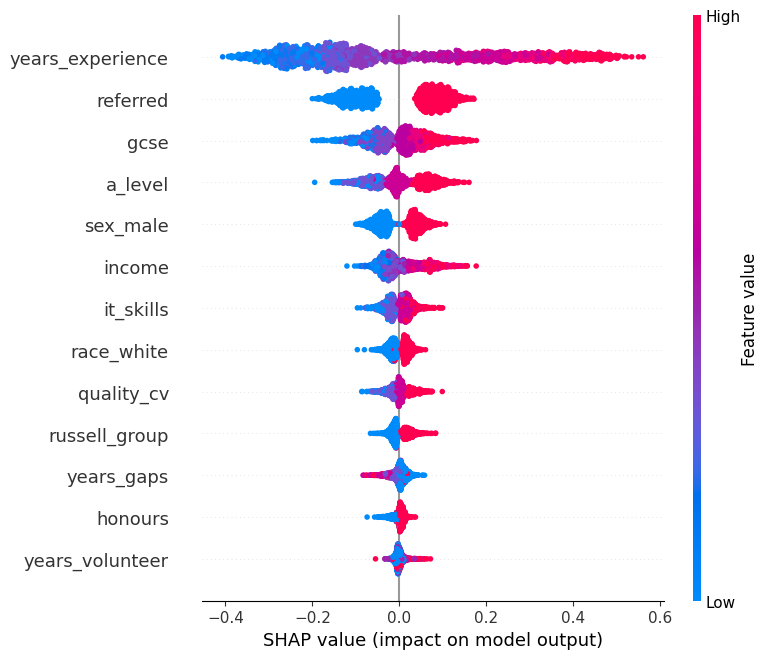

<Figure size 1000x300 with 0 Axes>

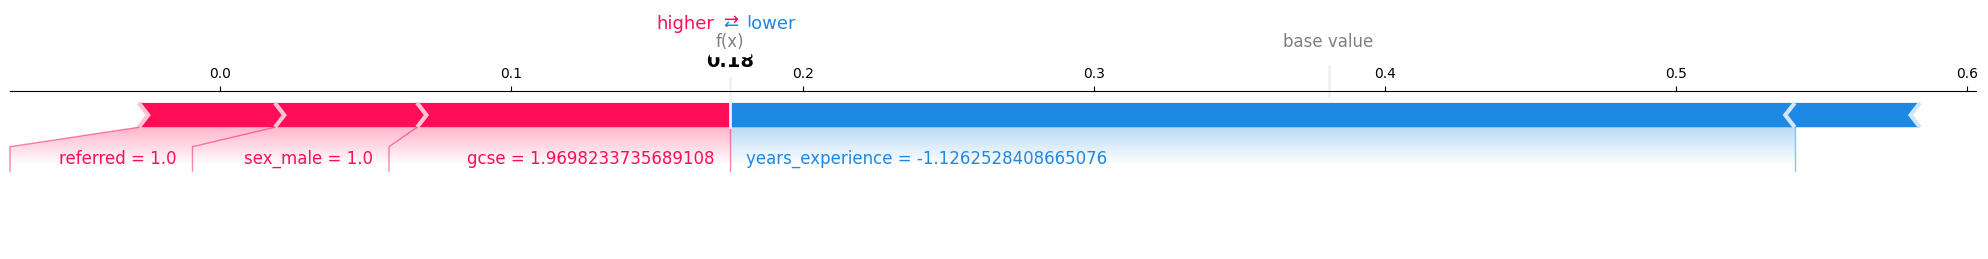

['random forest', 'fairness', 'bias mitigation', 'hiring'] is not of type 'string'
✅ Model card written to model_card.json


In [59]:
# 0. Install required libraries (run once in your notebook)
!pip install shap patra-toolkit

# 1. Imports
import pandas as pd
import numpy as np
import shap
import logging
import matplotlib.pyplot as plt
from patra_toolkit import ModelCard, Metric
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib

# 2. Load & prepare data
feature_names = dataset_transf.feature_names
X_rw_df = pd.DataFrame(dataset_transf.features, columns=feature_names)
if 'employed_yes' in X_rw_df.columns:
    X_rw_df = X_rw_df.drop(columns=['employed_yes'])
X_rw = X_rw_df.values
y_rw = dataset_transf.labels.ravel()
sample_weight = dataset_transf.instance_weights

test_url = (
    "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/"
    "refs/heads/master/artifacts/data/recruiting/processed/test.csv"
)
test = pd.read_csv(test_url)
X_test = test.drop(columns=['employed_yes'])
X_test = X_test[X_rw_df.columns]
y_test = test['employed_yes'].values

# 3. Train & save re-weighted model
clf_rw = RandomForestClassifier(random_state=42)
clf_rw.fit(X_rw, y_rw, sample_weight=sample_weight)
joblib.dump(clf_rw, "reweighted_model.pkl")
print("✅ Re-weighted model saved to reweighted_model.pkl")

# 4. Compute accuracy
y_pred = clf_rw.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Re-weighted Model Accuracy: {acc*100:.2f}%")

# 5. Compute fairness metrics
sr_w  = y_pred[test['race_white']==1].mean()
sr_nw = y_pred[test['race_white']==0].mean()
dpd   = sr_w - sr_nw
dpr   = sr_nw / sr_w if sr_w else np.nan

print("\nDemographic Parity (race_white):")
print(f"  Difference : {dpd:.3f}")
print(f"  Ratio      : {dpr:.3f}")

def tpr_fpr(y_true, y_pred, mask):
    tn, fp, fn, tp = confusion_matrix(y_true[mask], y_pred[mask]).ravel()
    return tp/(tp+fn), fp/(fp+tn)

mask_w  = test['race_white']==1
mask_nw = test['race_white']==0
tpr_w, fpr_w   = tpr_fpr(y_test, y_pred, mask_w)
tpr_nw, fpr_nw = tpr_fpr(y_test, y_pred, mask_nw)
tpr_diff = tpr_w - tpr_nw
fpr_diff = fpr_w - fpr_nw

print("\nEqualized Odds (race_white):")
print(f"  TPR diff : {tpr_diff:.3f}")
print(f"  FPR diff : {fpr_diff:.3f}")

# 6. Configure audit logging
logging.basicConfig(
    filename='audit.log',
    level=logging.INFO,
    format='%(asctime)s | %(levelname)s | %(message)s'
)
def log_prediction(cid, pred, shap_vals, feat_names):
    top = np.argsort(np.abs(shap_vals))[::-1][:3]
    top_feats = {feat_names[i]: float(shap_vals[i]) for i in top}
    logging.info(f"Candidate {cid} | pred={pred:.3f} | top_shap={top_feats}")

# 7. Explainability via SHAP
# explainer = shap.TreeExplainer(clf_rw)
# shap_values = explainer.shap_values(X_test)
# 7. Explainability via SHAP (with additivity check disabled)
explainer = shap.TreeExplainer(
    clf_rw,
    feature_perturbation="tree_path_dependent"
)
shap_values = explainer.shap_values(
    X_test,
    check_additivity=False
)


# 7a) Global summary plot
shap.summary_plot(
    shap_values[1],
    X_test,
    feature_names=X_test.columns,
    show=False
)
plt.savefig("shap_summary.png", bbox_inches="tight")


# 7b) Local force‐plot for candidate 0, top 5 features only
cid = 0
pred_prob = clf_rw.predict_proba(X_test[cid:cid+1])[0,1]
log_prediction(cid, pred_prob, shap_values[1][cid], list(X_test.columns))

# select top-5 features by absolute SHAP value
top_idxs        = np.argsort(np.abs(shap_values[1][cid]))[::-1][:5]
shap_vals_top5  = shap_values[1][cid][top_idxs]
feat_vals_top5  = X_test.iloc[cid].values[top_idxs]
feat_names_top5 = X_test.columns[top_idxs]

plt.figure(figsize=(10, 3))
shap.force_plot(
    explainer.expected_value[1],
    shap_vals_top5,
    feat_vals_top5,
    feature_names=list(feat_names_top5),
    matplotlib=True,
    show=False
)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("shap_local_top5.png", dpi=200, bbox_inches="tight")
plt.show()

# 8. Build & save a Patra Model Card
# 8. Build & save a Patra Model Card (with AIModel for performance)
from patra_toolkit import ModelCard, AIModel

# 8a) Instantiate the ModelCard with metadata
card = ModelCard(
    name="RF Re-weighed Hiring Model",
    version="1.0",
    short_description="RandomForest on re-weighted recruiting data for bias mitigation",
    full_description=(
        "RandomForestClassifier trained on CDEIUK re-weighted recruiting data. "
        "Instance weights applied per Kamiran & Calders to mitigate race bias."
    ),
    keywords=["random forest", "fairness", "bias mitigation", "hiring"],
    author="Faraz Badali",
    input_type="tabular",
    category="classification",
    foundational_model="None"
)

# 8b) Create an AIModel object to hold your trained model & accuracy
ai_model = AIModel(
    name="RF Re-weighed Hiring Model",
    version="1.0",
    description="RandomForestClassifier trained on re-weighted recruiting data to mitigate race bias",
    owner="team",
    location="reweighted_model.pkl",
    license="BSD-3-Clause",
    framework="sklearn",
    model_type="random_forest",
    test_accuracy=acc
)
# Populate its structure and attach it
ai_model.populate_model_structure(clf_rw)
card.ai_model = ai_model

# # 8c) Plug in your fairness & XAI artifacts exactly as before
# card.populate_bias({
#     "Statistical Parity Difference": dpd,
#     "Demographic Parity Ratio":      dpr,
#     "TPR Difference":                tpr_diff,
#     "FPR Difference":                fpr_diff
# })
card.populate_bias(
    true_labels=y_test,
    predicted_labels=y_pred,
    sensitive_feature_name="race_white",
    sensitive_feature_data=test['race_white'].values,
    model=clf_rw,
    dataset=X_test
)
# card.populate_xai(
#     train_dataset=X_test,
#     column_names=list(X_test.columns),
#     model=clf_rw,
#     n_features=5         # or however many top‐features you want plotted
# )

# 8c) Manually attach your explainability artifacts
# Create (or grab) the metadata dict
md = getattr(card, "metadata", {})
# Insert your PNGs under a custom key
md["explainability_artifacts"] = {
    "SHAP summary plot":     "shap_summary.png",
    "SHAP local top-5 plot": "shap_local_top5.png"
}
# Put it back on the card
card.metadata = md




# 8d) (Optional) capture your Python deps automatically
card.populate_requirements()

# 8e) Validate & write out your model_card.json
card.validate()
card.save("model_card.json")
print("✅ Model card written to model_card.json")




Hedef: DP Difference = 0 ve DP Ratio = 1

kısaca model beyazlara göre beyaz olmayanları daha az işe alıyor.

In [26]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# 1) Veri yükle (train CSV’ini daha önce AIF360’la işlemiş olsak da, baseline için raw train kullanıyoruz)
url_train = "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/processed/train.csv"
train = pd.read_csv(url_train)

# 2) Özelliklerden protected attribute’ı çıkar
X_train_ua = train.drop(columns=['employed_yes','race_white'])  # race_white yok
y_train   = train['employed_yes']

# 3) Aynı şekilde test setini hazırla
url_test = "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/processed/test.csv"
test = pd.read_csv(url_test)
X_test_ua = test.drop(columns=['employed_yes','race_white'])
y_test    = test['employed_yes']

# 4) RandomForest’i eğit
clf_ua = RandomForestClassifier(random_state=42)
clf_ua.fit(X_train_ua, y_train)

# 5) Tahmin ve Accuracy
y_pred_ua = clf_ua.predict(X_test_ua)
acc_ua = accuracy_score(y_test, y_pred_ua)
print(f"Unaware Model Accuracy: {acc_ua*100:.2f}%")

# 6) Demographic Parity (race_white) ölçümü
sr_white    = y_pred_ua[test['race_white']==1].mean()
sr_nonwhite = y_pred_ua[test['race_white']==0].mean()
dp_diff = sr_white - sr_nonwhite
dp_ratio= sr_nonwhite / sr_white
print("\nDemographic Parity (race_white):")
print(f"  Diff : {dp_diff:.3f}")
print(f"  Ratio: {dp_ratio:.3f}")

# 7) Equalized Odds (race_white)
def tpr_fpr(y_true, y_pred, mask):
    tn, fp, fn, tp = confusion_matrix(y_true[mask], y_pred[mask]).ravel()
    return tp/(tp+fn), fp/(fp+tn)

mask_w  = test['race_white']==1
mask_nw = test['race_white']==0
tpr_w, fpr_w   = tpr_fpr(y_test, y_pred_ua, mask_w)
tpr_nw, fpr_nw = tpr_fpr(y_test, y_pred_ua, mask_nw)
print("\nEqualized Odds (race_white):")
print(f"  TPR diff: {tpr_w - tpr_nw:.3f}")
print(f"  FPR diff: {fpr_w - fpr_nw:.3f}")


Unaware Model Accuracy: 84.20%

Demographic Parity (race_white):
  Diff : 0.268
  Ratio: 0.451

Equalized Odds (race_white):
  TPR diff: 0.053
  FPR diff: 0.072


In [27]:
!pip install aix360 scikit-learn



   ---------------------------------------- 0.0/58.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/58.4 MB ? eta -:--:--
   ---------------------------------------- 0.1/58.4 MB 812.7 kB/s eta 0:01:12
   ---------------------------------------- 0.2/58.4 MB 1.5 MB/s eta 0:00:39
   ---------------------------------------- 0.4/58.4 MB 2.6 MB/s eta 0:00:23
    --------------------------------------- 1.0/58.4 MB 4.7 MB/s eta 0:00:13
   - -------------------------------------- 2.1/58.4 MB 8.2 MB/s eta 0:00:07
   -- ------------------------------------- 4.2/58.4 MB 14.0 MB/s eta 0:00:04
   --- ------------------------------------ 5.8/58.4 MB 17.6 MB/s eta 0:00:03
   ---- ----------------------------------- 6.2/58.4 MB 17.3 MB/s eta 0:00:04
   ---- ----------------------------------- 6.9/58.4 MB 17.0 MB/s eta 0:00:04
   ----- ---------------------------------- 8.0/58.4 MB 16.5 MB/s eta 0:00:04
   ------ --------------------------------- 8.8/58.4 MB 16.6 MB/s eta 0:00:03
   --

In [28]:
from sklearn.linear_model import LogisticRegression
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.metrics import accuracy_score

# Temel veriler
X_train = train.drop(columns=['employed_yes','race_white'])
y_train = train['employed_yes']
sens_train = train['race_white']
X_test  = test.drop(columns=['employed_yes','race_white'])
y_test  = test['employed_yes']
sens_test = test['race_white']

# 1) Eps=0.01 ile güçlü DP kısıtı
est = LogisticRegression(solver='liblinear')
constraint = DemographicParity()
mitigator = ExponentiatedGradient(est, constraints=constraint, eps=0.01)
mitigator.fit(X_train, y_train, sensitive_features=sens_train)

# 2) Tahmin & accuracy
y_pred_eg = mitigator.predict(X_test)
print(f"EG (eps=0.01) Accuracy: {accuracy_score(y_test, y_pred_eg)*100:.2f}%")

# 3) DP hesapla
sr_w  = y_pred_eg[sens_test==1].mean()
sr_nw = y_pred_eg[sens_test==0].mean()
print("DP Diff:", sr_w - sr_nw)
print("DP Ratio:", sr_nw / sr_w)


EG (eps=0.01) Accuracy: 76.55%
DP Diff: 0.006760108161730616
DP Ratio: 0.9805963466020643


In [29]:
from fairlearn.postprocessing import ThresholdOptimizer

# 1) RandomForest ile baseline veya reweighed modelini eğit
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train, sample_weight=sample_weight)  # ya da sample_weight’ı çıkar

# 2) ThresholdOptimizer kur
post = ThresholdOptimizer(
    estimator=clf,
    constraints="demographic_parity",
    prefit=True
)
post.fit(X_test, y_test, sensitive_features=sens_test)

# 3) Yeni tahmin
y_pred_to = post.predict(X_test, sensitive_features=sens_test)

# 4) Ölçümler
acc_to = accuracy_score(y_test, y_pred_to)
sr_w2  = y_pred_to[sens_test==1].mean()
sr_nw2 = y_pred_to[sens_test==0].mean()

print(f"Post-proc Accuracy: {acc_to*100:.2f}%")
print("DP Diff:", sr_w2 - sr_nw2)
print("DP Ratio:", sr_nw2 / sr_w2)


Post-proc Accuracy: 79.00%
DP Diff: 0.0036120577929246722
DP Ratio: 0.9889981358967799


In [45]:
import sys
print("sys.version:", sys.version)
print("sys.executable:", sys.executable)


sys.version: 3.10.14 | packaged by Anaconda, Inc. | (main, Mar 21 2024, 16:20:14) [MSC v.1916 64 bit (AMD64)]
sys.executable: C:\Users\Faraz\anaconda3\python.exe


In [60]:
# import numpy as np
# from aix360.algorithms.contrastive.CEM import CEMExplainer

# # 3) Train your baseline model (or reuse an existing one)
# url = "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/processed/train.csv"
# train = pd.read_csv(url)
# X_train = train.drop(columns=['employed_yes','race_white'])
# y_train = train['employed_yes']

# model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

# # 4) Pick a single candidate from test set
# test_url = "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/processed/test.csv"
# test = pd.read_csv(test_url)
# X_test = test.drop(columns=['employed_yes','race_white'])
# idx = 5         # for example, row #5
# x = X_test.iloc[idx:idx+1].values   # shape (1, n_features)
# true_label = test.employed_yes.iloc[idx]

# # 5) LIME explanation
# lime_exp = LimeTabularExplainer(
#     training_data=X_train.values,
#     feature_names=X_train.columns,
#     discretize_continuous=True
# )
# exp = lime_exp.explain_instance(
#     x[0],
#     model.predict_proba,
#     num_features=5
# )
# print("LIME local feature contributions:")
# for feat, weight in exp.as_list():
#     print(f"  {feat}: {weight:.3f}")

# # 6) Counterfactual (CEM) explanation
# cem = CEMExplainer(
#     model_predict_fn = lambda inp: model.predict_proba(inp)[:,1],
#     mode            = 'PN',    # perturb-negate: generate counterfactuals for negative class
#     shape           = x.shape,
#     kappa           = 0.0,     # how strongly to enforce prediction flip
#     beta            = 0.1,     # feature‐sparsity trade-off
#     max_iterations  = 1000,
#     learning_rate   = 0.01
# )
# cfs = cem.explain(x, verbose=False)
# cf_example = cfs['PN'][0]     # counterfactual example for this candidate
# print("\nCounterfactual suggestion (minimal changes to flip decision):")
# for name, orig, new in zip(X_train.columns, x[0], cf_example):
#     if abs(new - orig) > 1e-3:
#         print(f"  {name}: {orig:.3f} → {new:.3f}")

In [62]:
!pip install streamlit shap dice-ml joblib pandas scikit-learn


  Using cached pandas-1.5.3-cp310-cp310-win_amd64.whl.metadata (12 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB 660.6 kB/s eta 0:00:15
   ---------------------------------------- 0.0/9.9 MB 660.6 kB/s eta 0:00:15
   ---------------------------------------- 0.0/9.9 MB 660.6 kB/s eta 0:00:15
   ---------------------------------------- 0.0/9.9 MB 660.6 kB/s eta 0:00:15
   ---------------------------------------- 0.0/9.9 MB 660.6 kB/s eta 0:00:15
   ---------------------------------------- 0.0/9.9 MB 660.6 kB/s eta 0:00:15
   ---------------------------------------- 0.0/9.9 MB 660.6 kB/s eta 0:00:15
   ---------------------------------------- 0.0/9.9 MB 660.6 kB/s eta 0:00:15
   ---------------------------------------- 0.0/9.9 MB 78.8 kB/s eta 0:02:05
   ------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
econml 0.15.1 requires shap<0.44.0,>=0.38.1, but you have shap 0.46.0 which is incompatible.
fairlearn 0.11.0 requires pandas>=2.0.3, but you have pandas 1.5.3 which is incompatible.
patra-toolkit 0.1.2 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
raiwidgets 0.36.0 requires fairlearn==0.7.0, but you have fairlearn 0.11.0 which is incompatible.
spacy-transformers 1.3.5 requires transformers<4.37.0,>=3.4.0, but you have transformers 4.46.1 which is incompatible.
torchaudio 2.2.2+cu121 requires torch==2.2.2+cu121, but you have torch 2.5.1 which is incompatible.


In [64]:
!pip install ipywidgets

# Contestability

In [67]:
import pandas as pd
import numpy as np
import joblib
import shap
import dice_ml
from dice_ml import Dice
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets

# 1) Load model & data
model = joblib.load("reweighted_model.pkl")
model.feature_names_in_ = X.columns.values
url = "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/processed/test.csv"
df = pd.read_csv(url)
X = df.drop(columns=["employed_yes"])
y = df["employed_yes"]



# 2) Init SHAP & DiCE
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")

dice_data = dice_ml.Data(
    dataframe=pd.concat([X, y], axis=1),
    continuous_features=X.columns.tolist(),
    outcome_name="employed_yes"
)
dice_model = dice_ml.Model(model=model, backend="sklearn")
dice_exp = Dice(dice_data, dice_model, method="random")

# 3) Build widgets
cid_w      = widgets.BoundedIntText(value=0, min=0, max=len(X)-1, description="Applicant ID:")
explain_b  = widgets.Button(description="Explain Decision", button_style="info")
appeal_txt = widgets.Textarea(placeholder="Describe your concern...", description="Appeal:")
submit_b   = widgets.Button(description="Submit Appeal", button_style="warning")
out        = widgets.Output()

# 4) Define callbacks
def on_explain(_):
    with out:
        clear_output()
        cid = cid_w.value
        row = X.iloc[[cid]]
        prob = model.predict_proba(row)[0,1]
        print(f"🔎 Hiring probability: {prob:.1%}\n")
        
        # SHAP bar chart
        shap_vals = explainer.shap_values(row, check_additivity=False)[1][0]
        expl = shap.Explanation(
            values=shap_vals,
            base_values=explainer.expected_value[1],
            data=row.values[0],
            feature_names=X.columns.tolist()
        )
        shap.plots.bar(expl, max_display=10, show=False)
        display(plt.gcf())
        plt.clf()
        
        # Counterfactual recourse
        cf = dice_exp.generate_counterfactuals(
            row, total_CFs=3, desired_class="opposite"
        )
        cf_df = cf.cf_examples_list[0].final_cfs_df
        print("🔄 Counterfactual suggestions:\n")
        display(cf_df)

def on_submit(_):
    with out:
        reason = appeal_txt.value.strip()
        if not reason:
            print("⚠️ Please enter a reason for your appeal.")
            return
        cid = cid_w.value
        ts = pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
        # Log to a file (or hook into your backend)
        with open("appeals.log", "a") as f:
            f.write(f"{ts} | ID {cid} | {reason}\n")
        print(f"✅ Appeal submitted for Applicant {cid} at {ts}")
        appeal_txt.value = ""

# 5) Wire up & display
explain_b.on_click(on_explain)
submit_b.on_click(on_submit)

display(widgets.VBox([
    cid_w,
    explain_b,
    widgets.HTML("<hr style='margin:10px 0;'>"),
    appeal_txt,
    submit_b,
    widgets.HTML("<hr style='margin:10px 0;'>"),
    out
]))